In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import numpy.linalg

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(20,8.27)})

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!pip install faraway

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 5.1 MB/s 


In [3]:
import faraway.datasets.mba
mba = faraway.datasets.mba.load()
mba.head()

,happy,money,sex,love,work
0,10,36,0,3,4
1,8,47,1,3,1
2,8,53,0,3,5
3,8,35,1,3,3
4,4,88,1,1,2


In [4]:
print(faraway.datasets.mba.DESCR)


Description:

     Data were collected from 39 students in a University of Chicago
     MBA class

Variables:

     A data frame with 39 observations on the following 5 variables.

     happy Happiness on a 10 point scale where 10 is most happy

     money family income in thousands of dollars

     sex 1 = satisfactory sexual activity, 0 = not

     love 1 = lonely, 2 = secure relationships, 3 = deep feeling of
          belonging and caring

     work 5 point scale where 1 = no job, 3 = OK job, 5 = great job

Source:

     George and McCulloch (1993) "Variable Selection via Gibbs
     Sampling" JASA, 88, 881-889



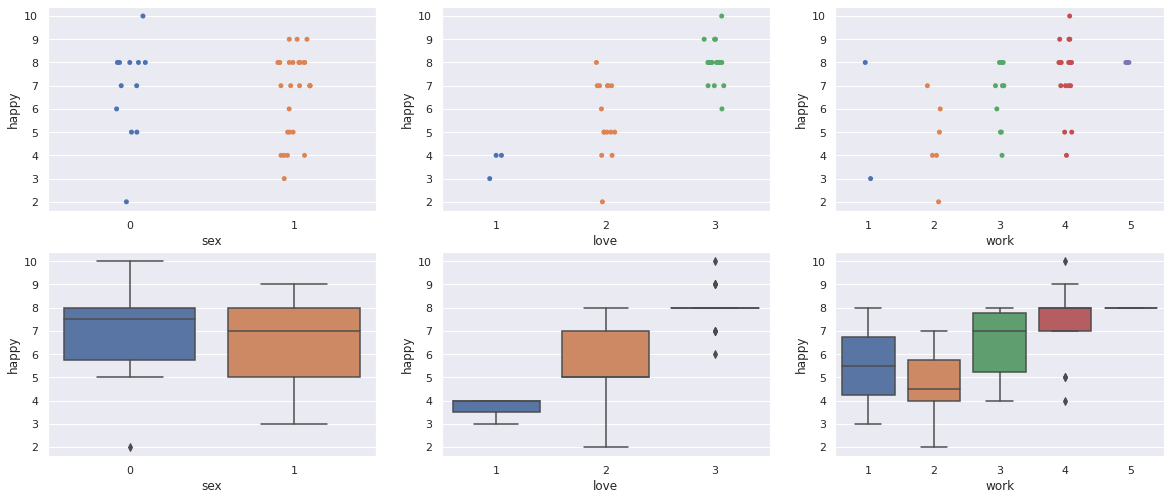

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 3)
fig.set_figwidth(20)
  
for i, col in enumerate(mba.columns[(mba.columns != "happy") & (mba.columns != "money")].values):
    sns.stripplot(x=col, y="happy", data=mba, ax=ax1[i])
    sns.boxplot(x=col, y="happy", data=mba, ax=ax2[i])


Observations: a strong relationship with $love$; less obvious, but still related to $work$.

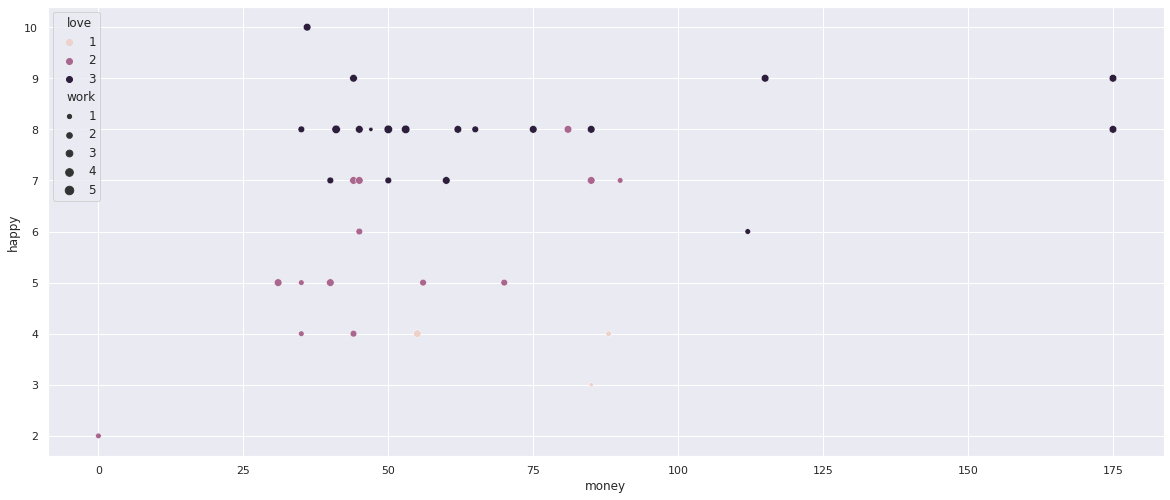

In [6]:
sns.scatterplot(x="money", y="happy", data=mba, hue="love", size="work")

There is a trend for $money$, but clearly a lot less represented then the one with $work$ and $love$.

In [7]:
mba.corr()["happy"].sort_values(ascending=False)

happy    1.000000
love     0.784219
work     0.539170
money    0.270942
sex     -0.032590
Name: happy, dtype: float64

<img src=attachment:2057cfe4-d5da-4f2a-bbc7-d48ccb8e7834.png width=700>

In [8]:
import faraway.utils
lmod = smf.ols(
    "happy ~ money + work + love + sex", 
    data=mba).fit()
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept -0.072  0.853   -0.08  0.9331
money      0.010  0.005    1.84  0.0749
work       0.476  0.199    2.39  0.0227
love       1.919  0.295    6.50  0.0000
sex       -0.149  0.419   -0.36  0.7240

n=39 p=5 Residual SD=1.058 R-squared=0.71


According to t-test, only $love$ is statistically significant at $\alpha=0.01$

In [9]:
mba["happy"].value_counts()

8     14
7      8
5      5
4      4
9      3
6      2
10     1
3      1
2      1
Name: happy, dtype: int64

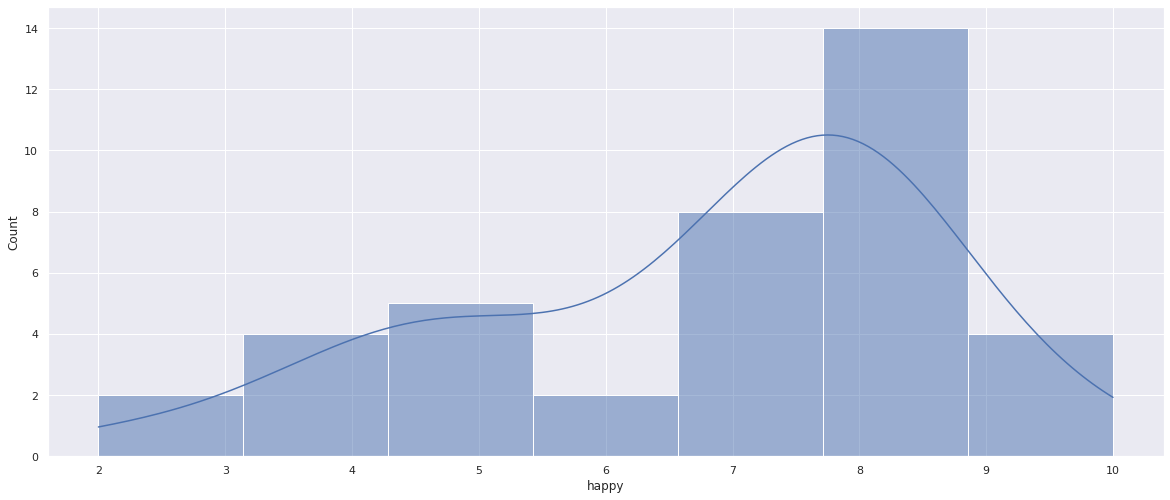

In [10]:
sns.histplot(x="happy", data=mba, kde=True)

In [11]:
mba["happy"].describe(), mba["happy"].skew()

(count    39.000000
 mean      6.743590
 std       1.859796
 min       2.000000
 25%       5.000000
 50%       7.000000
 75%       8.000000
 max      10.000000
 Name: happy, dtype: float64, -0.7426987042736272)

In [12]:
lmod.df_resid

34.0

The empirical distribution is somewhat left-skewed, </br>
thus questioning the normality assumption on the distribution of the noise,</br>
thus questioning the appropriateness of the t-test. </br></br>
Therefore, a good idea is to use the permutation test:

In [13]:
perm_n = 10
mba_c = mba.copy()
np.random.seed(42)
predictors = np.array(["love", "work", "money"])

for predictor in predictors:
    other_predictors = np.intersect1d(predictors, [predictor])
    permuted_predictor = predictor + "_perm"
    tstats= np.zeros(perm_n)

    for i in range(0, perm_n):
        mba_c[permuted_predictor] = np.random.permutation(
            np.copy(mba_c[predictor])
        )
        lmodi = smf.ols(
            'happy ~ ' + " + ".join(other_predictors) + " + " + permuted_predictor, 
            mba_c).fit()
        tstats[i] = lmodi.tvalues[permuted_predictor]

    print(predictor, "=", np.mean(np.abs(tstats) > np.abs(lmod.tvalues[predictor])))

love = 0.0
work = 0.0
money = 0.0


The $p$-values for $work$ and $money$ are less, </br> 
but still not enough to reject at $\alpha=0.01$ and $\alpha=0.05$ respectively

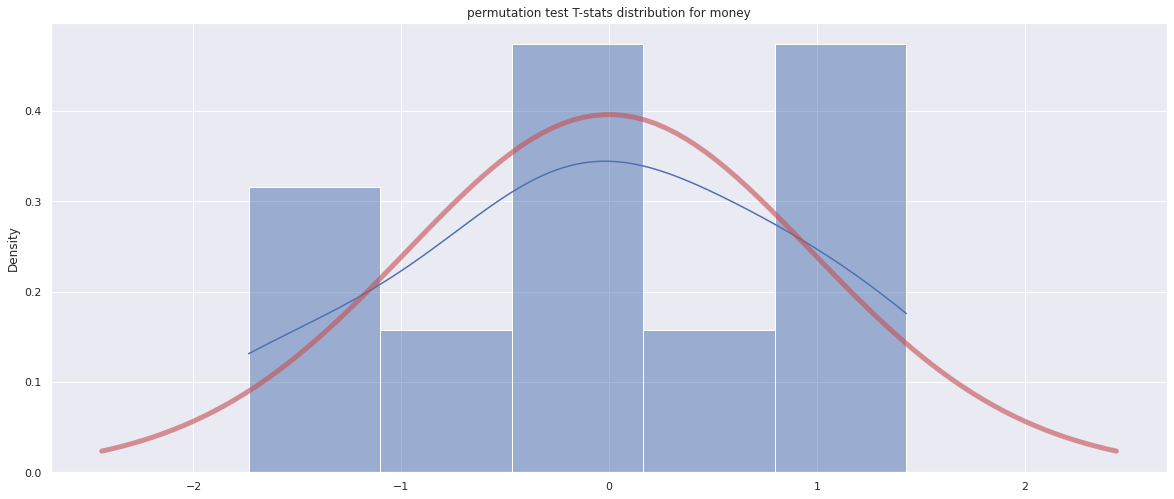

In [14]:
sns.histplot(
    tstats, 
    stat="density", 
    kde=True)
plt.title("permutation test T-stats distribution for money")

from scipy.stats import t
df=34
x = np.linspace(t.ppf(0.01, df),
                t.ppf(0.99, df), 100)
plt.plot(x, t.pdf(x, df),
       'r-', lw=5, alpha=0.6, label='t pdf')

In [15]:
for alpha in [0.05, 0.01]:
    print(lmod.conf_int(alpha), "alpha=", alpha, '\n')


                  0         1
Intercept -1.804657  1.660495
money     -0.001016  0.020172
work       0.070871  0.881286
love       1.318849  2.519709
sex       -0.999553  0.701538 alpha= 0.05 

                  0         1
Intercept -2.398154  2.253992
money     -0.004645  0.023801
work      -0.067933  1.020091
love       1.113171  2.725387
sex       -1.290909  0.992894 alpha= 0.01 



Once again, those conf intervals depend on the assumptioin of normality. </br>
Another way to obtain a conf interval -- bootstrap. </br>

In [17]:
np.random.seed(42)
breps = 10
coefmat = np.empty((breps, mba.shape[1] - 1))
resids = lmod.resid
preds = lmod.predict()


for i in range(0, breps):
    mba['ysamp'] = preds + np.random.choice(resids, mba.shape[0])
    lmodi = smf.ols(
        "ysamp ~ money + work + love + sex",  
        mba).fit()
    coefmat[i,:] = lmodi.params[lmodi.params != "Intercept"]
coefmat = pd.DataFrame(coefmat, columns=lmodi.params.index)

for alpha in [0.05, 0.01]:
    print("alpha=", alpha, '\n', coefmat.quantile((alpha/2, 1-alpha/2)))

alpha= 0.05 
        Intercept     money      work      love       sex
0.025  -0.653779  0.001597  0.188868  1.622339 -0.903327
0.975   0.891301  0.015900  0.829758  2.120087  0.190932
alpha= 0.01 
        Intercept     money      work      love       sex
0.005  -0.727845  0.000915  0.159018  1.610804 -0.999025
0.995   0.910809  0.015946  0.884945  2.126986  0.199358


There are two qualitative differences here:
* $money$ doesn't contain 0 at $\alpha=0.05$ (for breps=32000)
* $work$ **almost** doesn't contain 0 at $\alpha=0.01$ (for breps=32000: -0.004788)

In other words, with great deal of confidence we may conclude that </br>
$money$ and $work$ are statistically significant at $\alpha=0.05$ and $\alpha=0.01$ respectively.

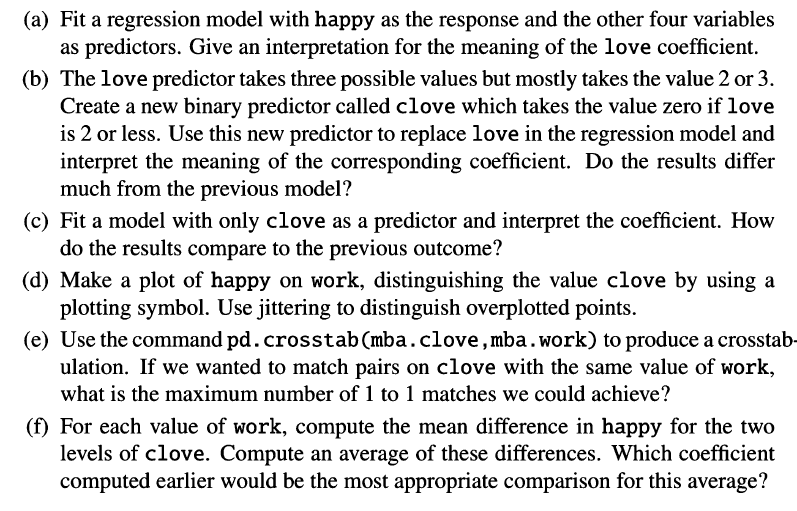

In [18]:
lmod = smf.ols(
    "happy ~ money + work + love + sex", 
    data=mba).fit()
lmod.sumary()

           coefs stderr tvalues pvalues
Intercept -0.072  0.853   -0.08  0.9331
money      0.010  0.005    1.84  0.0749
work       0.476  0.199    2.39  0.0227
love       1.919  0.295    6.50  0.0000
sex       -0.149  0.419   -0.36  0.7240

n=39 p=5 Residual SD=1.058 R-squared=0.71


In [19]:
mba["clove"] = mba["love"].map(lambda x: 0 if x <= 2 else 1)
mba.head()

,happy,money,sex,love,work,ysamp,clove
0,10,36,0,3,4,9.503228,1
1,8,47,1,3,1,5.917943,1
2,8,53,0,3,5,7.708609,1
3,8,35,1,3,3,5.833076,1
4,4,88,1,1,2,4.097220,0


In [20]:
lmod_p = smf.ols(
    "happy ~ money + work + clove + sex", 
    data=mba).fit()
lmod_p.sumary()

           coefs stderr tvalues pvalues
Intercept  3.454  0.840    4.11  0.0002
money      0.007  0.006    1.28  0.2076
work       0.544  0.214    2.55  0.0155
clove      2.296  0.412    5.58  0.0000
sex       -0.329  0.461   -0.71  0.4798

n=39 p=5 Residual SD=1.145 R-squared=0.66


The coefficient has increased.

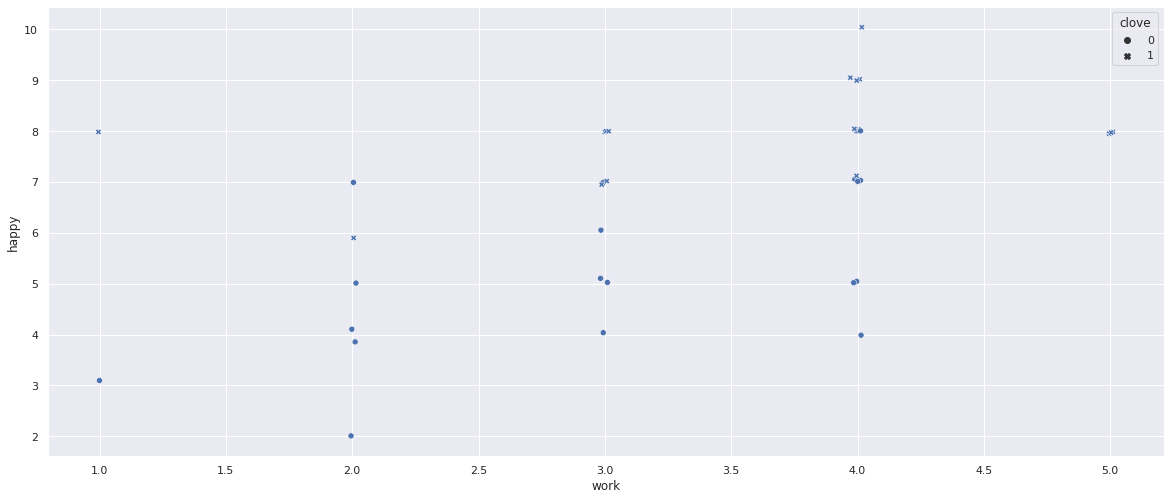

In [36]:
def jitter(values, sd):
    return values + np.random.normal(0, sd,values.shape)

sns.scatterplot(
    x=jitter(mba["work"], 0.01), 
    y=jitter(mba["happy"], 0.05), 
    style="clove", 
    data=mba
)

In [37]:
pd.crosstab(mba.clove, mba.work)

work,1,2,3,4,5
clove,,,,,
0,1,5,5,7,0
1,1,1,5,11,3


Conclusion: the maximum number of matched pairs with the same value of work -- </br>
for each value of work: (sum of the corresdonding column) // 2

In [ ]:
mba.groupby(["work", "clove"]).sum()